::: {.callout-note collapse="true"}
## Learning Outcomes
* Understand the standard workflow for fitting models in `sklearn`
* Describe the conceptual basis for gradient descent
* Compute the gradient descent update on a provided dataset
:::

At this point, we've grown quite familiar with the modeling process. We've introduced the concept of loss, used it to fit several types of models, and, most recently, extended our analysis to multiple regression. Along the way, we've forged our way through the mathematics of deriving the optimal model parameters in all of its gory detail. It's time to make our lives a little easier – let's implement the modeling process in code!

In this lecture, we'll explore three techniques for model fitting:

1. Translating our derived formulas for regression to Python
2. Using the `sklearn` Python package
3. Applying gradient descent for numerical optimization

## Implementing Derived Formulas in Code

Throughout this lecture, we'll refer to the `penguins` dataset. 

In [106]:
import pandas as pd
import seaborn as sns
import numpy as np

penguins = sns.load_dataset("penguins")
penguins = penguins[penguins["species"] == "Adelie"].dropna()
penguins.head(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


Suppose our goal is to predict the value of the `'bill depth'` for a particular penguin given its `'flipper length'`.

In [107]:
#| code-fold: false

# Define the design matrix, X...
X = penguins[["flipper_length_mm"]]

# ...as well as the target variable, y
y = penguins[["bill_depth_mm"]]

## Simple Linear Regression (SLR)

In the SLR framework we learned last week, this means we are saying our model for `bill depth`, $y$, is a linear function of `flipper length`, $x$:  

$$\hat{y} = \theta_0 + \theta_1 x$$

Let's do some EDA first.


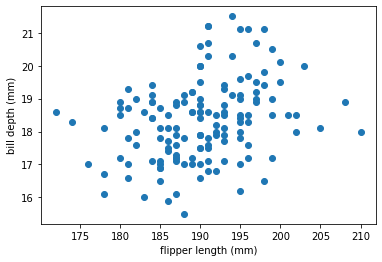

In [108]:
import matplotlib.pyplot as plt

plt.xlabel("flipper length (mm)")
plt.ylabel("bill depth (mm)")
plt.scatter(data = penguins, x = "flipper_length_mm", y = "bill_depth_mm")

Based on our EDA, there is a linear relationship, though it is somewhat weak.

### SLR w/ Derived Analytical Formulas

Let $\hat{\theta}_0$ and $\hat{\theta}_1$ be the choices that minimize the Mean Squared Error.


One approach to compute $\hat{\theta}_0$ and $\hat{\theta}_1$ is analytically, using the equations we derived in a previous lecture:

$$\hat{\theta}_0 = \bar{y} - \hat{\theta}_1 \bar{x}$$

$$\hat{\theta}_1 = r \frac{\sigma_y}{\sigma_x}$$

$$r = \frac{1}{n} \sum_{i=1}^{n}\left( \frac{x_i - x}{\sigma_x} \right) \left( \frac{y_i - y}{\sigma_y} \right) $$

Let's implement these using the base numpy library, which provides many important functions such as `.mean` and `.std` .

In [109]:
x = penguins["flipper_length_mm"]
y = penguins["bill_depth_mm"]

x_bar, sigma_x = np.mean(x), np.std(x)
y_bar, sigma_y = np.mean(y), np.std(y)
r = np.sum((x - x_bar) / sigma_x * (y - y_bar) / sigma_y) / len(x)

theta1_hat = r * sigma_y / sigma_x

theta0_hat = y_bar - theta1_hat * x_bar

print(f"bias parameter: {theta0_hat}, \nslope parameter: {theta1_hat}".format(theta0_hat,theta1_hat))

bias parameter: 7.297305899612297, 
slope parameter: 0.058126223695067675




### SLR Analytical Approach Performance

Let's first assess how "good"  this model is using a performance metric. For this exercise, let's use the MSE. As a review:

**Mean Squared Error**: We can compute this explicitly by averaging the square of the residuals $e_i$:

$$\large MSE  = \sum_{i=1}^n (y_i - \hat{y}_i)^2 = \frac{1}{n}\sum_{i=1}^n (e_i)^2 = \frac{1}{n}$$

In [110]:
# using our estimated parameter values to create a column containing our 
# SLR predictions and errors
penguins["analytical_preds_slr"] = theta0_hat + theta1_hat * penguins["flipper_length_mm"]

penguins["residual"] = penguins["bill_depth_mm"] - penguins["analytical_preds_slr"]
                                          
penguins

print("MSE: ", np.mean(penguins["residual"]**2))

MSE:  1.3338778799806363


Let's plot plot our results.


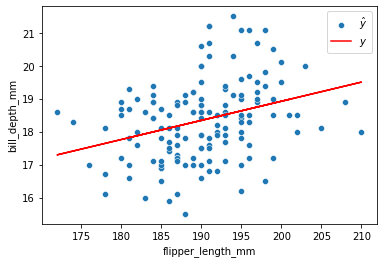

In [111]:
sns.scatterplot(data = penguins, x = "flipper_length_mm", y = "bill_depth_mm")
plt.plot(penguins["flipper_length_mm"], penguins["analytical_preds_slr"], 'r') # a line
plt.legend([r'$\hat{y}$', '$y$']);

### SLR w/ `sklearn`

We've already saved a lot of time (and avoided tedious calculations) by translating our derived formulas into code. However, we still had to go through the process of writing out the linear algebra ourselves. 

To make life *even easier*, we can turn to the `sklearn` Python library. `sklearn` is a robust library of machine learning tools used extensively in research and industry. It gives us a wide variety of in-built modeling frameworks and methods, so we'll keep returning to `sklearn` techniques as we progress through Data 100. 

Regardless of the specific type of model being implemented, `sklearn` follows a standard set of steps for creating a model. 

1. Create a model object. This generates a new instance of the model class. You can think of it as making a new copy of a standard "template" for a model. In pseudocode, this looks like:
    ```
    my_model = ModelName()
    ```
2. Fit the model to the `X` design matrix and `Y` target vector. This calculates the optimal model parameters "behind the scenes" without us explicitly working through the calculations ourselves. The fitted parameters are then stored within the model for use in future predictions:
    ```
    my_model.fit(X, Y)
    ```
3. Analyze the fitted parameters using `.coef_` or `.intercept_`, or use the fitted model to make predictions on the `X` input data using `.predict`. 

    ```
    my_model.coef_

    my_model.intercept_
    
    my_model.predict(X)
    ```

Let's put this into action with our multiple regression task. First, initialize an instance of the `LinearRegression` class.

In [112]:
#| code-fold: false
from sklearn.linear_model import LinearRegression

model = LinearRegression()


Next, fit the model instance to the design matrix `X` and target vector `Y` by calling `.fit`.

In [113]:
#| code-fold: false
model.fit(X, y)

LinearRegression()

And, lastly, generate predictions for $\hat{Y}$ using the `.predict` method. Here are the first 5 penguins in our dataset. How close are our analytical solution's predictions to our `sklearn` model's predictions?

In [114]:
#| code-fold: false
# Like before, show just the first 5 predictions. The output of predict is usually a np.array
penguins["sklearn_preds_slr"] = model.predict(X)
analytical_5 = penguins["sklearn_preds_slr"][:5].to_numpy()
print("Analytical solution: ", analytical_5)
sklearn_5 = penguins["analytical_preds_slr"][:5].to_numpy()
print("Sklearn solution: ", sklearn_5)



Analytical solution:  [17.81815239 18.10878351 18.63191952 18.51566707 18.3412884 ]
Sklearn solution:  [17.81815239 18.10878351 18.63191952 18.51566707 18.3412884 ]


You can also use the model to predict what the `bill depth` of a hypothetical penguin with `flipper length` of 185mm would have.

In [115]:
# this produces a warning since we
# did not specify what X this refers
# to, but since we only 
# have one input it is negligible

model.predict([[185]]) 


c:\Users\phanm\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([18.05065728])

We can also check if the fitted parameters,$\hat{\theta}_0,\hat{\theta}_1$, themselves are similar to our analytical solution. Note that since we can have at most 1 intercept in a SLR or OLS model, so we always get back a `scalar` value from `.intercept`. However, when OLS can have multiple coefficient values, so `.coef` returns an array.



In [116]:
theta0 = model.intercept_      # this a scalar
print("analytical bias term: ", theta0_hat)
print("sklearn bias term: ", theta0)


theta1 = model.coef_           # this an array
print("analytical coefficient terms: ", theta1_hat)
print("sklearn coefficient terms: ", theta1)

analytical bias term:  7.297305899612297
sklearn bias term:  7.297305899612306
analytical coefficient terms:  0.058126223695067675
sklearn coefficient terms:  [0.05812622]


### SLR `sklearn` Performance

The `sklearn` package also provides a function that computes the MSE from a list of observations and predictions. This avoids us having to manually compute MSE by first computing residuals.

[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

In [122]:
from sklearn.metrics import mean_squared_error
MSE_sklearn = mean_squared_error(penguins["bill_depth_mm"], penguins["sklearn_preds_slr"])
print("MSE: ", MSE_sklearn)


MSE:  1.3338778799806374


We've generated the exact same predictions and error as before, but without any need for manipulating matrices ourselves!  


## Multiple Linear Regression (OLS)


In the previous lecture, we expressed multiple linear regression using matrix notation.

$$\hat{\mathbb{Y}} = \mathbb{X}\theta$$

### OLS w/ Derived Analytical Formulas

We used a geometric approach to derive the following expression for the optimal model parameters under MSE error:

$$\hat{\theta} = (\mathbb{X}^T \mathbb{X})^{-1}\mathbb{X}^T \mathbb{Y}$$

That's a whole lot of matrix manipulation. How do we implement it in Python?

There are three operations we need to perform here: multiplying matrices, taking transposes, and finding inverses. 

* To perform matrix multiplication, use the `@` operator
* To take a transpose, call the `.T` attribute of an array or DataFrame
* To compute an inverse, use `numpy`'s in-built method `np.linalg.inv`



In [136]:
#| code-fold: false
X = penguins[["flipper_length_mm", "body_mass_g"]].copy()

X["bias"] = np.ones(len(X))
y = penguins["bill_depth_mm"]


theta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
theta_hat  

0     0.009828
1     0.001477
2    11.002995
dtype: float64

Note that since we added "bias" last, `theta_hat[2]` is our estimated value for the $\theta_0$. To make predictions using our newly-fitted model coefficients, matrix-multiply `X` and `theta_hat`.

In [137]:
#| code-fold: false
y_hat = X.to_numpy() @ theta_hat

# Show just the first 5 predictions to save space on the page
y_hat[:5]
penguins["analytical_preds_ols"] = y_hat

Note, this technique doesn't work if our X is **not invertible**. 

### OLS w/ `sklearn`

We can actually compute the optimal parameters very easily using sklearn, using the exact code that we wrote earlier. Note: sklearn does NOT use the normal equations. Instead it uses  gradient descent, a technique we will learn about soon, which can minimize ANY function, not just the MSE.


In [138]:
# creating our design matrix.
# Note:
#  - no bias term needed here bc of sklearn automatically includes one
#  - to remove the intercept term, set the fit_intercept = true in LinearRegression constructor.

X_2d = penguins[["flipper_length_mm", "body_mass_g"]]
y = penguins["bill_depth_mm"]
model_2d = LinearRegression() # note fit_intercept=True by default
model_2d.fit(X_2d, y)

LinearRegression()

Now we again have a model with which we can use to make predictions. For example, we can ask our model about a penguin's bill depth if they have 185-mm flipper length and 3750 g body mass.

In [139]:
penguins["sklearn_predictions_ols"] = model_2d.predict(X_2d)
model_2d.predict([[185, 3750]]) 
# since we have a 2d data matrix, we maintain the same 
# row-column expectation for our inputs. 

c:\Users\phanm\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([18.36187501])

Just like with SLR, we cam also extract the coefficient estimates using `.coef_` and `.intercept`. The reason why `.intercept` returns an array should now be more clear.

In [145]:
print(f"(sklearn) theta0: {model_2d.intercept_}")
print(f"(analytical) theta0 {theta_hat[2]}")
print(f"(sklearn) theta1: {model_2d.coef_[0]}")
print(f"(analytical) theta1 {theta_hat[0]}")
print(f"(sklearn) theta2: {model_2d.coef_[1]}")
print(f"(analytical) theta2 {theta_hat[1]}")


(sklearn) theta0: 11.002995277447068
(analytical) theta0 11.002995277447535
(sklearn) theta1: 0.009828486885248712
(analytical) theta1 0.0098284868852512
(sklearn) theta2: 0.0014774959083212896
(analytical) theta2 0.0014774959083213644


### Visualizing Our 2D Linear Model Predictions

When we have two axis with which we can change an input, moving along this input plan creates a 2d plane with which we can get model outputs for. For example, for every single penguin with a `flipper length` , we also must specify a `body mass`. These two values in combination will help us predict the `bill depth`. Thus, we see that the predictions all lie in a 2d-plane. In higher dimensions, they all lie in a "hyperplane". 

Text(0.5, 0.5, 'body_mass_g')

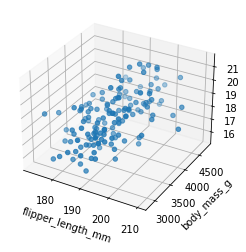

In [148]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(penguins["flipper_length_mm"], penguins["body_mass_g"], penguins["bill_depth_mm"])
plt.xlabel('flipper_length_mm')
plt.ylabel('body_mass_g')


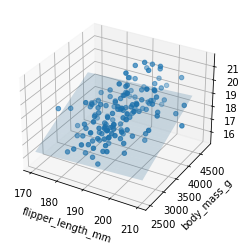

In [149]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(penguins["flipper_length_mm"], penguins["body_mass_g"], penguins["bill_depth_mm"])
xx, yy = np.meshgrid(range(170, 220, 10), range(2500, 4500, 100))
zz = ( 11.0029 + 0.00982 * xx + 0.001477 * yy) # thetas_using_sklearn
ax.plot_surface(xx, yy, zz, alpha=0.2)
plt.xlabel('flipper_length_mm')
plt.ylabel('body_mass_g')
plt.gcf().savefig("plane.png", dpi = 300, bbox_inches = "tight")


## Gradient Descent

At this point, we're fairly comfortable with fitting a regression model under MSE risk (indeed, we've done it three times now!). It's important to remember, however, that the results we've found previously apply to one very specific case: the equations we used above are only relevant to a linear regression model using MSE as the cost function. In reality, we'll be working with a wide range of model types and objective functions, not all of which are as straightforward as the scenario we've discussed previously. This means that we need some more generalizable way of fitting a model to minimize loss. 

To do this, we'll introduce the technique of **gradient descent**.

### Minimizing a 1D Function

Let's shift our focus away from MSE to consider some new, arbitrary cost function. You can think of this function as outputting the empirical risk associated with some parameter `theta`. 

<img src="images/arbitrary.png" alt='arbitrary' width='600'>

#### The Naive Approach: Guess and Check

Above, we saw that the minimum is somewhere around 5.3ish. Let's see if we can figure out how to find the exact minimum algorithmically from scratch. One way very slow and terrible way would be manual guess-and-check.

In [171]:
def arbitrary(x):
    return (x**4 - 15*x**3 + 80*x**2 - 180*x + 144)/10

def simple_minimize(f, xs):
    # Takes in a function f and a set of values xs. 
    # Calculates the value of the function f at all values x in xs
    # Takes the minimum value of f(x) and returns the corresponding value x 
    y = [f(x) for x in xs]  
    return xs[np.argmin(y)]

simple_minimize(arbitrary, np.linspace(1, 7, 20))

5.421052631578947

#### Scipy.optimize.minimize

One way to minimize this mathematical function is to use the `scipy.optimize.minimize` function. It takes a function and a starting guess and tries to find the minimum.

In [175]:
from scipy.optimize import minimize

# takes a function f and a starting point x0 and returns a readout 
# with the optimal input value of x which minimizes f
minimize(arbitrary, x0 = 3.5)

      fun: -0.13827491292966557
 hess_inv: array([[0.73848255]])
      jac: array([6.48573041e-06])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 3
     njev: 10
   status: 0
  success: True
        x: array([2.39275266])

Our choice of start point can affect the outcome. For example if we start to the left, we get stuck in the local minimum on the left side.

In [173]:
minimize(arbitrary, x0 = 1)

#here we see the optimal value is different from before

      fun: -0.13827491294422317
 hess_inv: array([[0.74751575]])
      jac: array([-3.7997961e-07])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 7
     njev: 8
   status: 0
  success: True
        x: array([2.3927478])

`scipy.optimize.minimize` is great. It may also seem a bit magical. How could you write a function that can find the minimum of any mathematical function? There are a number of ways to do this, which we'll explore in today's lecture, eventually arriving at the important idea of **gradient descent**, which is the principle that `scipy.optimize.minimize` uses.

It turns out that under the hood, the `fit` method for `LinearRegression` models uses gradient descent. Gradient descent is also how much of machine learning works, including even advanced neural network models. 

In Data 100, the gradient descent process will usually be invisible to us, hidden beneath an abstraction layer. However, to be good data scientists, it's important that we know the basic principles beyond the optimization functions that harness to find optimal parmaeters.


### Digging into Gradient Descent
Looking at the function across this domain, it is clear that the function's minimum value occurs around $\theta = 5.3$. Let's pretend for a moment that we *couldn't* see the full view of the cost function. How would we guess the value of $\theta$ that minimizes the function? 

It turns out that the first derivative of the function can give us a clue. In the plots below, the line indicates the value of the derivative of each value of $\theta$. The derivative is negative where it is red and positive where it is green.



Say we make a guess for the minimizing value of $\theta$. Remember that we read plots from left to right, and assume that our starting $\theta$ value is to the left of the optimal $\hat{\theta}$. If the guess "undershoots" the true minimizing value – our guess for $\theta$ is not quite at the value of the $\hat{\theta}$ that truly minimizes the function – the derivative will be **negative** in value. This means that if we increase $\theta$ (move further to the right), then we **can decrease** our loss function further. If this guess "overshoots" the true minimizing value, the derivative will be positive in value, implying the converse.

<img src="images/step.png" alt='step' width='600'>

We can use this pattern to help formulate our next guess for the optimal $\hat{\theta}$. Consider the case where we've undershot $\theta$ by guessing too low of a value. We'll want our next guess to be greater in value than the previous guess – that is, we want to shift our guess to the right. You can think of this as following the slope "downhill" to the function's minimum value.

<img src="images/neg_step.png" alt='neg_step' width='600'>

If we've overshot $\hat{\theta}$ by guessing too high of a value, we'll want our next guess to be lower in value – we want to shift our guess for $\hat{\theta}$ to the left. 

<img src="images/pos_step.png" alt='pos_step' width='600'>

### Formalizing Gradient Descent

These observations lead us to the **gradient descent update rule**:
$$\theta^{(t+1)} = \theta^{(t)} - \alpha \frac{dL}{d\theta}$$

Begin with our guess for $\hat{\theta}$ at timestep $t$. To find our guess for $\hat{\theta}$ at the next timestep, $t+1$, subtract a multiple of the objective function's derivative, $\frac{dL}{d\theta}$. We've replaced the generic function $f$ with $L$ to indicate that we are minimizing loss.

* If our guess $\theta^{(t)}$ was too low (undershooting $\hat{\theta}$), $\frac{dL}{d\theta}$ will be negative. Subtracting a negative number from $\theta^{(t)}$ will *increase* the value of the next guess, $\theta^{(t+1)}$. The guess will shift to the right.
* If our guess $\theta^{(t)}$ was too high (overshooting $\hat{\theta}$), $\frac{dL}{d\theta}$ will be positive. Subtracting a positive number from $\theta^{(t)}$ will *decrease* the value of the next guess, $\theta^{(t+1)}$. The guess will shift to the left.

Put together, this captures the same behavior we reasoned through above. We repeatedly update our guess for the optimal $\theta$ until we've completed a set number of updates, or until each additional update iteration does not change the value of $\theta$. In this second case, we say that gradient descent has **converged** on a solution. 

The $\alpha$ term in the update rule is known as the **learning rate**. It represents the size of each gradient descent update step – in other words, how "far" should we step to the left or right with each updated guess? A high value of $\alpha$ will lead to large differences in value between consecutive guesses for $\hat{\theta}$; a low value of $\alpha$ will result in smaller differences in value between consecutive guesses. This is the first example of a **hyperparameter**, a parameter that is hand picked by the data scientist that changes the model's behavior, in the course.


In [162]:
# define the derivative of the arbitrary function we want to minimize
def derivative_arbitrary(x):
    return (4*x**3 - 45*x**2 + 160*x - 180)/10

def gradient_descent(df, initial_guess, alpha, n):
    """Performs n steps of gradient descent on df using learning rate alpha starting
       from initial_guess. Returns a numpy array of all guesses over time."""
    guesses = [initial_guess]
    current_guess = initial_guess
    while len(guesses) < n:
        current_guess = current_guess - alpha * df(current_guess)
        guesses.append(current_guess)
        
    return np.array(guesses)

# calling our function gives us the path that gradient descent takes for 20 steps 
# with a learning rate of 0.3 starting at theta = 4
trajectory = gradient_descent(derivative_arbitrary, 4, 0.3, 20)
trajectory

array([4.        , 4.12      , 4.26729664, 4.44272584, 4.64092624,
       4.8461837 , 5.03211854, 5.17201478, 5.25648449, 5.29791149,
       5.31542718, 5.3222606 , 5.32483298, 5.32578765, 5.32614004,
       5.32626985, 5.32631764, 5.32633523, 5.3263417 , 5.32634408])

Above, we've simply run our algorithm a fixed number of times. More sophisticated implementations will stop based on a variety of different stopping criteria, e.g. error getting too small, error getting too large, etc. We will not discuss these in our course.

### Loss Terminology

We use the word "loss" in two different (but very related) contexts in this course.

- In general, loss is the cost function that measures how far off model's prediction(s) is(are) from the actual value(s).

    - Per-datapoint loss is a cost function that measures the cost of $y$ vs $\hat{y}$ for a particular datapoint. 
    - Loss (without any adjectives) is generally a cost function measured across all datapoints. Often times, *empirical risk* is *average per-datapoint loss*.

- We prioritize using the latter term, because we don't particularly look at a given datapoint's loss when optimizing a model.
    
    - In other words, the dataset-level loss is the objective function that we'd like to minimize using gradient descent.
    - We achieve this minimization by using **per-datapoint** loss values.


### Application of 1D Gradient Descent

We’ve seen how to find the optimal parameters for a 1D linear model for the penguin dataset:

- Using the derived equations from Data 8.
- Using `sklearn`.
    - Uses gradient descent under the hood!

In real practice in this course, we’ll usually use `sklearn`. But for now, let’s see how we can do the gradient descent ourselves.

Let's consider a case where we have a linear model with no offset. 

$$\hat{y} = \theta_1 x$$

We want to find the parameter $\theta_1$ such that the L2 loss is minimized. In sklearn, this is easy. To avoid fitting an intercept, we set `fit_intercept` to false.

In [164]:
model = LinearRegression(fit_intercept = False)
df = sns.load_dataset("tips")
model.fit(df[["total_bill"]], df["tip"])
model.coef_ # the optimal tip percentage is 14.37%

array([0.1437319])

### Creating an Explicit MSE Function

To employ gradient descent and do this ourselves, we need to define a function upon which we can use gradient descent. Suppose we select the L2 loss as our loss function. In this case, our goal will be to minimize the mean squared error. 

Let's start by writing a function that computes the MSE for a given choice of $\theta_1$ on our dataset.

In [168]:
def mse_single_arg(theta1):
    """Returns the MSE on our data for the given theta1"""
    x = df["total_bill"]
    y_obs = df["tip"]
    y_hat = theta1 * x
    return np.mean((y_hat - y_obs) ** 2)

mse_single_arg(0.1437)
# The minimum loss value that we can achieve is 1.178 dollars on average away from the truth

1.1781165940051928

### Plotting the MSE Function

Since we only have 1 parameter, we can simply cross reference our results with a simnple plot. We do not want to always do this since some functions can have thousands of inputs, making them difficult to plot. We can plot the MSE as a function of `theta1`. It turns out to look pretty smooth, and quite similar to a parabola.

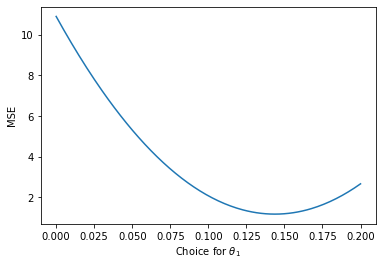

In [169]:
theta1s = np.linspace(0, 0.2, 200)
x = df["total_bill"]
y_obs = df["tip"]

MSEs = [mse_single_arg(theta1) for theta1 in theta1s]

plt.plot(theta1s, MSEs)
plt.xlabel(r"Choice for $\theta_1$")
plt.ylabel(r"MSE");

The minimum appears to be around $\theta_1 = 0.14$. We can once again check this naively.

In [176]:
simple_minimize(mse_single_arg, np.linspace(0, 0.2, 21))

0.14

As before, what we're doing is computing all the starred values below and then returning the $\theta_1$ that goes with the minimum value.

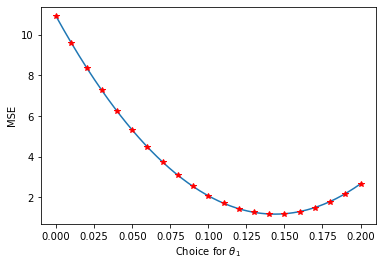

In [177]:
theta1s = np.linspace(0, 0.2, 200)
sparse_theta1s = np.linspace(0, 0.2, 21)

loss = [mse_single_arg(theta1) for theta1 in theta1s]
sparse_loss = [mse_single_arg(theta1) for theta1 in sparse_theta1s]

plt.plot(theta1s, loss)
plt.plot(sparse_theta1s, sparse_loss, 'r*')
plt.xlabel(r"Choice for $\theta_1$")
plt.ylabel(r"MSE");

#### Using Scipy.Optimize.minimize

In [ ]:
import scipy.optimize
from scipy.optimize import minimize
minimize(mse_single_arg, x0 = 0)

#### Using Our Gradient Descent Function

Another approach is to use our 1D gradient descent algorithm from earlier. This is the exact same function as earlier. We can run it for 100 steps and see where it ultimately ends up.

In [179]:
def mse_loss_derivative_single_arg(theta_1):
    """Returns the derivative of the MSE on our data for the given theta1"""
    x = df["total_bill"]
    y_obs = df["tip"]
    y_hat = theta_1 * x
    
    return np.mean(2 * (y_hat - y_obs) * x)

gradient_descent(mse_loss_derivative_single_arg, 0.05, 0.0001, 100)[-5:]

array([0.14372404, 0.14372478, 0.14372545, 0.14372605, 0.1437266 ])

### Gradient Notation

Consider the 2D function: $$f(\theta_0, \theta_1) = 8\theta_0^2 + 3\theta_0\theta_1$$

For a function of 2 variables, $f(\theta_0, \theta_1)$ we define the gradient as $\nabla_\theta f = \frac{\partial f}{\partial \theta_0} \vec{i} +  \frac{\partial f}{\partial \theta_1} \vec{j} $, where $\vec{i}$ and $\vec{j}$ are the unit vectors in the $\theta_0$ and $\theta_1$ directions.

$$\frac{\partial f}{\partial \theta_0} = 16\theta_0 + 3\theta_1$$

$$\frac{\partial f}{\partial \theta_1} = 3\theta_0$$

$$\nabla_\theta f =  (16\theta_0 + 3\theta_1)\vec{i} + (3\theta_0)\vec{j}$$

We can also write it in column vector notation. 

$$\nabla_\theta f =  \begin{bmatrix} \frac{\partial f}{\partial \theta_0} \\ \frac{\partial f}{\partial \theta_1} \\... \end{bmatrix}$$

EX: $\nabla_\theta f =  \begin{bmatrix}16\theta_0 + 3\theta_1 \\ 3\theta_0\end{bmatrix}$

You should read these gradients as:

- $\frac{\partial f}{\partial \theta_0}$ : If I nudge the 1st model weight, what happens to loss?
-  $\frac{\partial f}{\partial \theta_1}$ :If I nudge the 2nd model weight, what happens to loss?
- etc.


### Multidimensional Gradient Descent
We're in good shape now: we've developed a technique to find the minimum value of a more complex objective function. 

The function we worked with above was one-dimensional – we were only minimizing the function with respect to a single parameter, $\theta$. However, as we've seen before, we often need to optimize a cost function with respect to several parameters (for example, when selecting the best model parameters for multiple linear regression). We'll need to extend our gradient descent rule to *multidimensional* objective functions.

Now suppose we improve our model so that we want to predict the tip from the total_bill plus a constant offset, in other words:

$$\textrm{tip} = \theta_0 + \theta_1 \textrm{bill}$$

To put this in more concrete terms what this means, let's return to the familiar case of simple linear regression with MSE loss.
$$\text{MSE}(\theta_0,\:\theta_1) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 = \frac{1}{n} \sum_{i=1}^{n} (y_i - \theta_0 - \theta_1 x)^2$$

Now, loss is expressed in terms of *two* parameters, $\theta_0$ and $\theta_1$. Rather than a one-dimensional loss function as we had above, we are now dealing with a two-dimensional **loss surface**.

In [160]:
# This code is for illustration purposes only
# It contains a lot of syntax you have not seen
import plotly.graph_objects as go

model = LinearRegression(fit_intercept = False)
df = sns.load_dataset("tips")
df["bias"] = 1
model.fit(df[["bias","total_bill"]], df["tip"])
model.coef_

uvalues = np.linspace(0, 2, 10)
vvalues = np.linspace(0, 0.2, 10)
(u,v) = np.meshgrid(uvalues, vvalues)
thetas = np.vstack((u.flatten(),v.flatten()))

X = df[["bias","total_bill"]].to_numpy()
Y = df["tip"].to_numpy()

def mse_loss_single_arg(theta):
    return mse_loss(theta, X, Y)

def mse_loss(theta, X, y_obs):
    y_hat = X @ theta
    return np.mean((y_hat - Y) ** 2)    

MSE = np.array([mse_loss_single_arg(t) for t in thetas.T])

loss_surface = go.Surface(x=u, y=v, z=np.reshape(MSE, u.shape))

ind = np.argmin(MSE)
optimal_point = go.Scatter3d(name = "Optimal Point",
    x = [thetas.T[ind,0]], y = [thetas.T[ind,1]], 
    z = [MSE[ind]],
    marker=dict(size=10, color="red"))

fig = go.Figure(data=[loss_surface, optimal_point])
fig.update_layout(scene = dict(
    xaxis_title = "theta0",
    yaxis_title = "theta1",
    zaxis_title = "MSE"))
fig.show()

Though our objective function looks a little different, we can use the same principles as we did earlier to locate the optimal model parameters. Notice how the minimum value of MSE, marked by the red dot in the plot above, occurs in the "valley" of the loss surface. Like before, we want our guesses for the best pair of $(\theta_0,\:\theta_1)$ to move "downhill" towards this minimum point. 

The difference now is that we need to update guesses for *both* $\theta_0$ and $\theta_1$:
$$\theta_0^{(t+1)} = \theta_0^{(t)} - \alpha \frac{dL}{d\theta_0} \qquad \qquad \theta_1^{(t+1)} = \theta_1^{(t)} - \alpha \frac{dL}{d\theta_1}$$

We can tidy this statement up by using vector notation:
$$\begin{bmatrix}
           \theta_{0}^{(t+1)} \\
           \theta_{1}^{(t+1)} \\
         \end{bmatrix}
=
\begin{bmatrix}
           \theta_{0}^{(t)} \\
           \theta_{1}^{(t)} \\
         \end{bmatrix}
- \alpha
\begin{bmatrix}
           \frac{dL}{d\theta_{0}} \\
           \frac{dL}{d\theta_{1}} \\
         \end{bmatrix}
$$

To save ourselves from writing out long column vectors, we'll introduce some new notation. $\vec{\theta}^{(t)}$ is a column vector of guesses for each model parameter $\theta_i$ at timestep $t$. We call $\nabla_{\vec{\theta}} L$ the **gradient vector.** In plain English, it means "take the derivative of loss, $L$, with respect to each model parameter in $\vec{\theta}$."

$$\vec{\theta}^{(t+1)}
= \vec{\theta}^{(t)} - \alpha \nabla_{\vec{\theta}} L
$$

### We have `Multidimensional Gradient Descent` at home

First, we need to be able to easily determine the gradient for any pair of values, $\theta_0, \theta_1$.

In [187]:
tips_with_bias = df.copy()
tips_with_bias["bias"] = 1
X = tips_with_bias[["bias", "total_bill"]]
X.head(5)

def mse_gradient(theta, X, y_obs):
    """Returns the gradient of the MSE on our data for the given theta"""    
    x0 = X.iloc[:, 0]
    x1 = X.iloc[:, 1]
    dth0 = np.mean(-2 * (y_obs - theta[0]*x0 - theta[1]*x1) * x0)
    dth1 = np.mean(-2 * (y_obs - theta[0]*x0 - theta[1]*x1) * x1)
    return np.array([dth0, dth1])

def mse_gradient_single_arg(theta):
    """Returns the gradient of the MSE on our data for the given theta"""
    X = tips_with_bias[["bias", "total_bill"]]
    y_obs = tips_with_bias["tip"]
    return mse_gradient(theta, X, y_obs)

X = tips_with_bias[["bias", "total_bill"]]
y_obs = tips_with_bias["tip"]
ex1_mse = mse_gradient(np.array([0, 0]), X, y_obs)

print(f"Gradient for values theta0 = 0 and theta1 = 0 : {ex1_mse}")

Gradient for values theta0 = 0 and theta1 = 0 : [  -5.99655738 -135.22631803]


Using our previously previously defined `gradient_descent` function, we can see if our intuition extends to higher dimensions. 

In [188]:
#print out the last 10 guesses our algorithm outputs to save space
guesses = gradient_descent(mse_gradient_single_arg, np.array([0, 0]), 0.001, 10000)[-10:]


### (Mini-)Batch, and Stochastic Descent

Formally, the algorithm we derived above is called **batch gradient descent.** For each iteration of the algorithm, the derivative of loss is computed across the entire batch of available data. While this update rule works well in theory, it is not practical in all circumstances. For large datasets (with perhaps billions of data points), finding the gradient across all the data is incredibly computationally taxing. 

**Mini-batch gradient descent** tries to address this issue. In mini-batch descent, only a subset of the data is used to compute an estimate of the gradient. For example, we might consider only 10% of the total data at each gradient descent update step. At the next iteration, a different 10% of the data is sampled to perform the following update. Once the entire dataset has been used, the process is repeated. Each complete "pass" through the data is known as a **training epoch**.

In the extreme case, we might choose a batch size of only 1 data point – that is, a single data point is used to estimate the gradient of loss with each update step. This is known as **stochastic gradient descent**.

Batch gradient descent is a deterministic technique – because the entire dataset is used at each update iteration, the algorithm will always advance towards the minimum of the loss surface. In contrast, both mini-batch and stochastic gradient descent involve an element of randomness. Since only a subset of the full data is used to update the guess for $\vec{\theta}$ at each iteration, there's a chance the algorithm will not progress towards the true minimum of loss with each update. Over the longer term, these stochastic techniques should still converge towards the optimal solution. 

The diagrams below represent a "bird's eye view" of a loss surface from above. Notice that batch gradient descent takes a direct path towards the optimal $\hat{\theta}$. Stochastic gradient descent, in contrast, "hops around" on its path to the minimum point on the loss surface. This reflects the randomness of the sampling process at each update step.

<img src="images/stochastic.png" alt='stochastic' width='600'>


### A Word on Covexity
In our analysis above, we focused our attention on the global minimum of the loss function. You may be wondering: what about the local minimum just to the left? 

If we had chosen a different starting guess for $\theta$, or a different value for the learning rate $\alpha$, we may have converged on the local minimum, rather than on the true optimum value of loss. 

<img src="images/local.png" alt='local' width='600'>

If the loss function is **convex**, gradient descent is guaranteed to find the global minimum of the objective function. Formally, a function $f$ is convex if:
$$tf(a) + (1-t)f(b) \geq f(ta + (1-t)b)$$

To put this into words: if you drew a line between any two points on the curve, all values on the curve must be *on or below* the line. Importantly, any local minimum of a convex function is also its global minimum. 

<img src="images/convex.png" alt='convex' width='600'>

In summary, non-convex loss functions can cause problems with optimization. This means that our choice of loss function is an key factor in our modeling process. It turns out that MSE *is* convex, which is a major reason why it is such a popular choice of loss function.